In [2]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import compress_pickle

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'correlation_shares_syn_weight_210829_2share'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData

from weight_database import WeightDatabase
grc_pc_db = WeightDatabase()



mf_grc_db = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/mf_grc/gen_201229_setup01_syndb_threshold_20_coalesced.gz')

def weight_fn(syn):
    props = syn['props']['area_erode0']
    if 'mesh_area' in props:
        area = props['mesh_area']
    else:
        area = 0
    if area < .01125:
        area = 0
    return area
    diameter = math.sqrt(area/math.pi)*2
    return diameter*1000

grc_pc_db_f = '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/grc_axons/' \
              'gen_210429_setup01_syndb_threshold_10_coalesced.gz'

grc_pc_db.load_syn_db(
#     '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/grc_axons/gen_201224_setup01_syndb_threshold_10_coalesced.gz',
    grc_pc_db_f,
    weight_fn=weight_fn)

weights_db = grc_pc_db.get_weights()

full_axon_list = list(set(list(weights_db.keys())))

def compute_mf_share():
    count = defaultdict(lambda: defaultdict(list))
    grcs = full_axon_list
    for i in range(len(grcs)):
        grc_i = grcs[i]
        if grc_i in mf_grc_db:
            i_set = set(mf_grc_db[grc_i].keys())
            for j in range(len(grcs)):
                if i == j:
                    continue
                grc_j = grcs[j]
                if grc_j in mf_grc_db:
                    j_set = set(mf_grc_db[grcs[j]].keys())
                    common_mfs = i_set & j_set
                    if len(common_mfs) == 2:
                        count[grcs[i]][len(common_mfs)].append(grcs[j])
    return count

shares = compute_mf_share()
#print(shares)

In [17]:

mpd = MyPlotData()
mpd_raw = MyPlotData()
hist = defaultdict(int)
# weights_db = weightdb.get_weights()

random.seed(0)

array_w1 = []
array_w2 = []

random.seed(0)

processed = set()
for n1 in sorted(shares.keys()):
    for share_count, n2s in shares[n1].items():
        for n2 in sorted(n2s):
            if (n1, n2) in processed:
                continue
            processed.add((n1, n2))
            processed.add((n2, n1))
            common_pcs = set(weights_db[n1].keys()) & set(weights_db[n2].keys())
            for pc in common_pcs:
                w1 = weights_db[n1][pc]
                w2 = weights_db[n2][pc]
                # we will only process single synapse connections for simplicity
#                 if len(w1) > 1 or len(w2) >1:
#                     continue
                random.shuffle(w1)
                random.shuffle(w2)
#                 if random.random() < .5:
#                     w1, w2 = w2, w1
                w1 = w1[0]
                w2 = w2[0]
#                 w1 /= 1000
#                 w2 /= 1000
                array_w1.append(w1)
                array_w2.append(w2)
                mpd_raw.add_data_point(
                    w1=w1,
                    w2=w2,
                    )
                mpd_raw.add_data_point(
                    w1=w2,
                    w2=w1,
                    )


In [13]:
import scipy.stats

scipy.stats.pearsonr(array_w1, array_w2)

#array_w1

(0.046410676696989915, 0.08492093393822199)

In [14]:
import scipy.stats

scipy.stats.spearmanr(array_w1, array_w2)

#array_w1

SpearmanrResult(correlation=0.03214595075844397, pvalue=0.23288421454416072)

In [15]:
print(len(array_w1))

1379


Height: 4, Aspect: 1.33


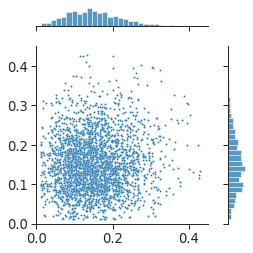

SpearmanrResult(correlation=0.038677493123903124, pvalue=0.15113923313480032)
n = 1379 pairs


In [28]:
importlib.reload(my_plot); my_plot.my_jointplot(
    mpd_raw,
    x="w1",
    y="w2",
    s=4,
    xlim=(0, .45),
    ylim=(0, .45),
    kind='scatter',
    save_filename=f'{script_n}.svg',
    height=4,
    context='paper',
    show=True,
    )

print(scipy.stats.spearmanr(array_w1, array_w2))
print(f'n = {len(array_w1)} pairs')

# importlib.reload(my_plot); my_plot.my_jointplot(
#     mpd_raw,
#     x="w1",
#     y="w2",
#     ylim=[None, .9],
#     xlim=[None, .9],
#     # y_axis_label='Distance from PCL (um)',
#     # x_axis_label='X offset from soma (um)',
#     # xlim=[-200, 200],
#     # kind=f'{kind}',
#     kind='kde',
#     save_filename=f'{script_n}_kde.svg',
#     show=True,
#     )

Height: 3, Aspect: 1.0


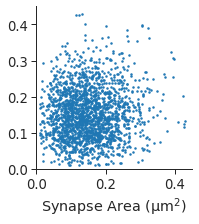

In [46]:
mpd_raw_lite = copy.copy(mpd_raw)
random.shuffle(mpd_raw_lite.data)
mpd_raw_lite.data = mpd_raw_lite.data[:2000]
importlib.reload(my_plot); my_plot.my_relplot(
    mpd_raw_lite,
    x="w1",
    y="w2",
    xlim=(0, .45),
    ylim=(0, .45),
    kind='scatter',
    save_filename=f'{script_n}_lite.svg',
    context='paper',
    x_axis_label='Synapse Area (µm$^2$)',
    edgecolor=None,
    s=1,
    height=3,
    width=3,
    show=True,
    )

Height: 4, Aspect: 1.33


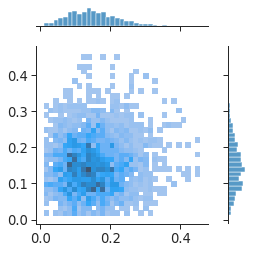

In [27]:
importlib.reload(my_plot); my_plot.my_jointplot(
    mpd_raw,
    x="w1",
    y="w2",
#     s=3,
    kind='hist',
    height=4,
    save_filename=f'{script_n}_hist.svg',
    context='paper',
    show=True,
    )

In [ ]:
importlib.reload(my_plot); my_plot.my_jointplot(
    mpd_raw,
    x="w1",
    y="w2",
#     s=3,
    kind='kde',
#     save_filename=f'{script_n}.svg',
    show=True,
    )